## NEXT RIDE LOCATION PREDICTION

In [248]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')


In [249]:
df=pd.read_csv('UberDataset.csv')
print(df.shape)
print(df.columns)
df.head()

(1156, 7)
Index(['START_DATE', 'END_DATE', 'CATEGORY', 'START', 'STOP', 'MILES',
       'PURPOSE'],
      dtype='object')


,START_DATE,END_DATE,CATEGORY,START,STOP,MILES,PURPOSE
0,01-01-2016 21:11,01-01-2016 21:17,Business,Fort Pierce,Fort Pierce,5.1,Meal/Entertain
1,01-02-2016 01:25,01-02-2016 01:37,Business,Fort Pierce,Fort Pierce,5.0,NaN
2,01-02-2016 20:25,01-02-2016 20:38,Business,Fort Pierce,Fort Pierce,4.8,Errand/Supplies
3,01-05-2016 17:31,01-05-2016 17:45,Business,Fort Pierce,Fort Pierce,4.7,Meeting
4,01-06-2016 14:42,01-06-2016 15:49,Business,Fort Pierce,West Palm Beach,63.7,Customer Visit


In [250]:
print(df[df['START_DATE']=='Totals'])
df = df[df['START_DATE'] != 'Totals']

     START_DATE END_DATE CATEGORY START STOP    MILES PURPOSE
1155     Totals      NaN      NaN   NaN  NaN  12204.7     NaN


In [251]:
df['START_DATE'] = df['START_DATE'].replace({'/': '-'}, regex=True)
df['END_DATE'] = df['END_DATE'].replace({'/': '-'}, regex=True)


In [252]:
df['START_DATE'] = pd.to_datetime(df['START_DATE'], format='%m-%d-%Y %H:%M')
df['END_DATE'] = pd.to_datetime(df['END_DATE'], format='%m-%d-%Y %H:%M')

In [253]:
df['Days_of_Week'] = df['START_DATE'].dt.day_name()
df['Hour_of_Day'] = df['START_DATE'].dt.hour
df['Week_of_Year'] = df['START_DATE'].dt.isocalendar().week

In [254]:
df.isnull().sum()

START_DATE        0
END_DATE          0
CATEGORY          0
START             0
STOP              0
MILES             0
PURPOSE         502
Days_of_Week      0
Hour_of_Day       0
Week_of_Year      0
dtype: int64

In [255]:
df=df.drop(columns=['PURPOSE'])


In [256]:
len(df['START'].unique())

177

<Axes: xlabel='CATEGORY'>

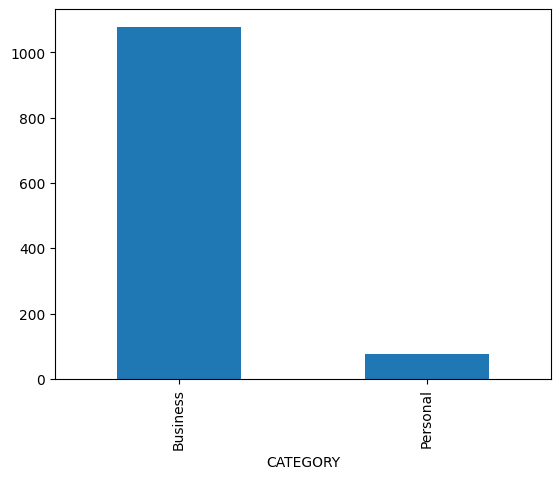

In [257]:
df['CATEGORY'].value_counts().plot(kind='bar')

<Axes: xlabel='Days_of_Week'>

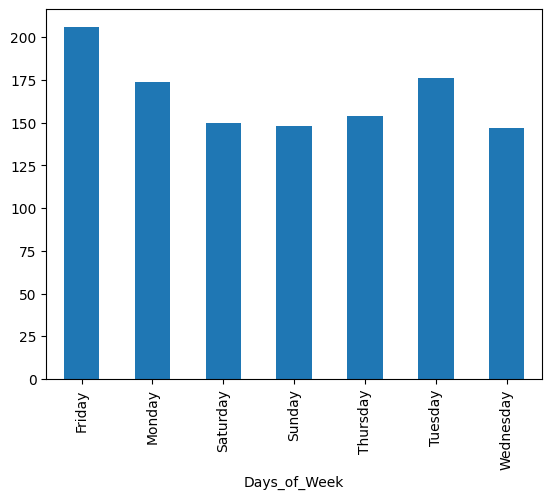

In [258]:
df.groupby('Days_of_Week',sort=True).size().plot(kind='bar')

<Axes: xlabel='Week_of_Year'>

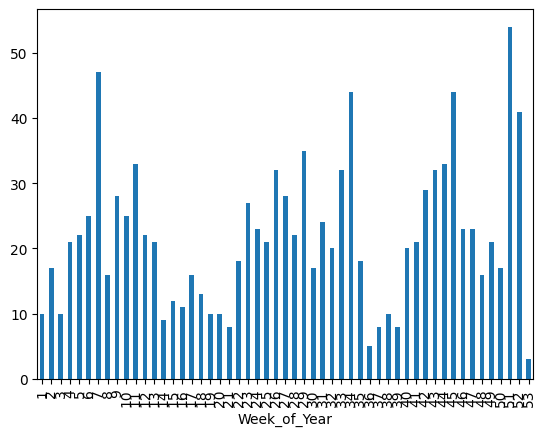

In [259]:
df.groupby('Week_of_Year',sort=True).size().plot(kind='bar')

<Axes: xlabel='Hour_of_Day'>

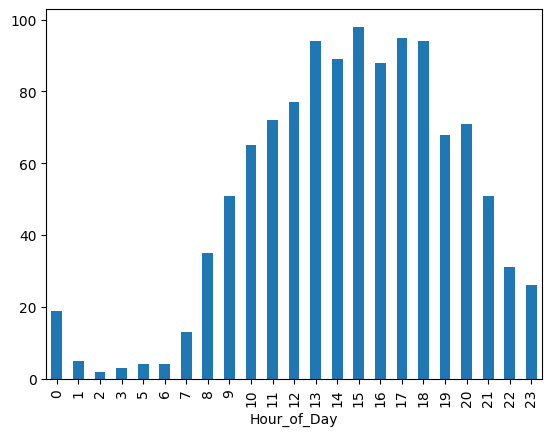

In [260]:
df.groupby('Hour_of_Day',sort=True).size().plot(kind='bar')

Clear seasonal trends. The number rides are clearly affected by hour of the day, week of the year and even what day it is.
Best model for a time series forecast would be SARIMA

In [261]:
df['START'].value_counts().head(7)

START
Cary                201
Unknown Location    148
Morrisville          85
Whitebridge          68
Islamabad            57
Durham               37
Lahore               36
Name: count, dtype: int64

In [262]:
df['STOP'].value_counts().head(7)

STOP
Cary                203
Unknown Location    149
Morrisville          84
Whitebridge          65
Islamabad            58
Durham               36
Lahore               36
Name: count, dtype: int64

In [263]:
print(df[(df['START']=='Unknown Location') & (df['STOP']=='Unknown Location')].shape)

(86, 9)


In [264]:
# i make a model just to predict unknown location based on end trip location amd miles
df['original_index'] = df.index   
small_df=df.copy()
unknown_df=small_df[(small_df['START'] == 'Unknown Location') | (small_df['STOP'] == 'Unknown Location')].copy()
known_trips = small_df[(small_df['START'] != 'Unknown Location') & 
                       (small_df['STOP'] != 'Unknown Location')].copy()

In [265]:
df['original_index'].head()

0    0
1    1
2    2
3    3
4    4
Name: original_index, dtype: int64

In [266]:
# Create features
known_trips['day_of_week'] = known_trips['START_DATE'].dt.dayofweek
known_trips['month'] = known_trips['START_DATE'].dt.month
known_trips['end_hour'] = known_trips['END_DATE'].dt.hour
known_trips['hour'] = known_trips['START_DATE'].dt.hour

# Create location encoders
location_encoder = LabelEncoder()
all_locations = pd.concat([known_trips['START'], known_trips['STOP']]).unique()
location_encoder.fit(all_locations)

# Encode known trips
known_trips['START_encoded'] = location_encoder.transform(known_trips['START'])
known_trips['STOP_encoded'] = location_encoder.transform(known_trips['STOP'])

In [267]:
model_stop = RandomForestClassifier(n_estimators=100, random_state=42)

# Features: START_encoded, MILES, temporal features
X_stop = known_trips[['START_encoded', 'MILES', 'day_of_week', 'month', 'hour', 'end_hour']]
y_stop = known_trips['STOP_encoded']

model_stop.fit(X_stop, y_stop)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [268]:
model_start = RandomForestClassifier(n_estimators=100, random_state=42)

X_start = known_trips[['STOP_encoded', 'MILES', 'day_of_week', 'month', 'hour','end_hour']]
y_start = known_trips['START_encoded']

model_start.fit(X_start, y_start)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [269]:
features_both = known_trips[['MILES', 'day_of_week', 'month', 'hour','end_hour']].values
kmeans = KMeans(n_clusters=min(20, len(known_trips)), random_state=42)
known_trips['trip_cluster'] = kmeans.fit_predict(features_both)

# For each cluster, find most common START-STOP pairs
cluster_patterns = known_trips.groupby('trip_cluster').agg({
    'START_encoded': lambda x: x.mode()[0] if len(x.mode()) > 0 else None,
    'STOP_encoded': lambda x: x.mode()[0] if len(x.mode()) > 0 else None
}).reset_index()

In [270]:
def predict_locations(df):
    """
    Predict unknown START and STOP locations
    """
    df = df.copy()
    
    # Create temporal features
    df['START_DATE'] = pd.to_datetime(df['START_DATE'])
    df['day_of_week'] = df['START_DATE'].dt.dayofweek
    df['month'] = df['START_DATE'].dt.month
    df['hour'] = df['START_DATE'].dt.hour
    df['end_hour'] = pd.to_datetime(df['END_DATE']).dt.hour
    
    predictions = []
    probabilities = []
    
    for idx, row in df.iterrows():
        start_known = row['START'] != 'Unknown Location'
        stop_known = row['STOP'] != 'Unknown Location'
        
        if start_known and stop_known:
            # Both known, no prediction needed
            pred_start, pred_stop = row['START'], row['STOP']
            probabilities.append(1.0)
            
        elif start_known and not stop_known:
            # Predict STOP based on START
            try:
                start_encoded = location_encoder.transform([row['START']])[0]
                features = np.array([[start_encoded, row['MILES'], 
                                    row['day_of_week'], row['month'], row['hour'], row['end_hour']]])
                stop_encoded = model_stop.predict(features)[0]
                probabilities.append(model_stop.predict_proba(features).max())
                pred_stop = location_encoder.inverse_transform([stop_encoded])[0]
                pred_start = row['START']
            except:
                pred_stop, pred_start = row['STOP'], row['START']
                
        elif not start_known and stop_known:
            # Predict START based on STOP
            try:
                stop_encoded = location_encoder.transform([row['STOP']])[0]
                features = np.array([[stop_encoded, row['MILES'], 
                                    row['day_of_week'], row['month'], row['hour'], row['end_hour']]])
                start_encoded = model_start.predict(features)[0]
                probabilities.append(model_start.predict_proba(features).max())
                pred_start = location_encoder.inverse_transform([start_encoded])[0]
                pred_stop = row['STOP']
            except:
                pred_stop, pred_start = row['STOP'], row['START']
                
        else:
            # Both unknown - use cluster-based prediction
            try:
                features = np.array([[row['MILES'], row['day_of_week'], 
                                    row['month'], row['hour'], row['end_hour']]])
                cluster = kmeans.predict(features)[0]
                probabilities.append(None)
                
                if cluster in cluster_patterns['trip_cluster'].values:
                    cluster_row = cluster_patterns[cluster_patterns['trip_cluster'] == cluster].iloc[0]
                    if pd.notna(cluster_row['START_encoded']):
                        pred_start = location_encoder.inverse_transform([int(cluster_row['START_encoded'])])[0]
                        
                    else:
                        pred_start = 'Unknown Location'
                        
                    if pd.notna(cluster_row['STOP_encoded']):
                        pred_stop = location_encoder.inverse_transform([int(cluster_row['STOP_encoded'])])[0]
                    else:
                        pred_stop = 'Unknown Location'
                else:
                    pred_start, pred_stop = 'Unknown Location', 'Unknown Location'
            except:
                pred_start, pred_stop = 'Unknown Location', 'Unknown Location'
        
        predictions.append({
            'original_index': idx,
            'predicted_START': pred_start,
            'predicted_STOP': pred_stop,
            'confidence': probabilities[-1]
        })
    
    return pd.DataFrame(predictions)

In [271]:
pred_los=predict_locations(unknown_df)
result_df = unknown_df.merge(pred_los, left_index=True, right_on='original_index')
result_df = result_df[['START', 'STOP', 'MILES', 'START_DATE', 
                       'predicted_START', 'predicted_STOP', 'confidence', 'original_index']]

print(f"Predicted {len(result_df)} trips with unknown locations")
result_df.head()

Predicted 211 trips with unknown locations


,START,STOP,MILES,START_DATE,predicted_START,predicted_STOP,confidence,original_index
0,Katunayaka,Unknown Location,43.7,2016-02-16 03:21:00,Katunayaka,Greater Greenspoint,0.25,108
1,Unknown Location,Colombo,14.1,2016-02-16 08:29:00,Cary,Colombo,0.52,109
2,Nugegoda,Unknown Location,3.6,2016-02-16 17:40:00,Nugegoda,Whitebridge,0.24,116
3,Unknown Location,Colombo,14.7,2016-02-17 13:18:00,Cary,Colombo,0.36,117
4,Unknown Location,Unknown Location,23.5,2016-02-18 08:19:00,Cary,Cary,NaN,121


In [272]:
result_df.shape

(211, 8)

In [273]:
new_df=df.merge(result_df, left_index=True, right_on='original_index', how='left')
new_df['final_START'] = np.where(
    (new_df['START_x'] == 'Unknown Location') & new_df['predicted_START'].notna(),
    new_df['predicted_START'],
    new_df['START_x']
)

new_df['final_STOP'] = np.where(
    (new_df['STOP_x'] == 'Unknown Location') & new_df['predicted_STOP'].notna(),
    new_df['predicted_STOP'],
    new_df['STOP_x']
)
print(new_df[new_df['final_START']=='Unknown Location'].shape)
print(new_df[new_df['final_STOP']=='Unknown Location'].shape)


(0, 21)
(0, 21)


In [274]:
print(f"Original df shape: {df.shape}")
print(f"Result df shape: {result_df.shape}")
print(f"Merged df shape: {new_df.shape}")
print(f"Null predictions count: {new_df['predicted_START'].isna().sum()}")

# Check column names
print("\nColumn names after merge:")
print(new_df.columns.tolist())

Original df shape: (1155, 10)
Result df shape: (211, 8)
Merged df shape: (1155, 21)
Null predictions count: 944

Column names after merge:
['original_index', 'START_DATE_x', 'END_DATE', 'CATEGORY', 'START_x', 'STOP_x', 'MILES_x', 'Days_of_Week', 'Hour_of_Day', 'Week_of_Year', 'original_index_x', 'START_y', 'STOP_y', 'MILES_y', 'START_DATE_y', 'predicted_START', 'predicted_STOP', 'confidence', 'original_index_y', 'final_START', 'final_STOP']


In [275]:
new_df.shape

(1155, 21)

In [276]:
columns_drop=[ 'START_y', 'STOP_y','CATEGORY','MILES_y', 'START_DATE_y', 'predicted_START', 'predicted_STOP',  'original_index_y']
new_df=new_df.drop(columns=columns_drop)
new_df[new_df['START_x']=='Unknown Location']

,original_index,START_DATE_x,END_DATE,START_x,STOP_x,MILES_x,Days_of_Week,Hour_of_Day,Week_of_Year,original_index_x,confidence,final_START,final_STOP
1.0,109,2016-02-16 08:29:00,2016-02-16 09:34:00,Unknown Location,Colombo,14.1,Tuesday,8,7,109,0.52,Cary,Colombo
3.0,117,2016-02-17 13:18:00,2016-02-17 14:04:00,Unknown Location,Colombo,14.7,Wednesday,13,7,117,0.36,Cary,Colombo
4.0,121,2016-02-18 08:19:00,2016-02-18 08:27:00,Unknown Location,Unknown Location,23.5,Thursday,8,7,121,NaN,Cary,Cary
5.0,122,2016-02-18 14:03:00,2016-02-18 14:45:00,Unknown Location,Islamabad,12.7,Thursday,14,7,122,0.15,Downtown,Islamabad
7.0,124,2016-02-18 18:44:00,2016-02-18 18:58:00,Unknown Location,Islamabad,5.2,Thursday,18,7,124,0.29,Houston,Islamabad
...,...,...,...,...,...,...,...,...,...,...,...,...,...
202.0,1129,2016-12-28 17:02:00,2016-12-28 17:16:00,Unknown Location,Kar?chi,4.4,Wednesday,17,52,1129,0.71,Kar?chi,Kar?chi
204.0,1134,2016-12-29 11:28:00,2016-12-29 12:00:00,Unknown Location,Kar?chi,11.9,Thursday,11,52,1134,0.43,Kar?chi,Kar?chi
206.0,1141,2016-12-29 19:50:00,2016-12-29 20:10:00,Unknown Location,Kar?chi,4.1,Thursday,19,52,1141,0.82,Kar?chi,Kar?chi
208.0,1144,2016-12-29 23:14:00,2016-12-29 23:47:00,Unknown Location,Kar?chi,12.9,Thursday,23,52,1144,0.37,Kar?chi,Kar?chi


NOW WE DONT HAVE UNKNOWN LOCATIONS 

In [277]:
# REMOVING THE _x suffix
new_df=new_df.rename(columns={
    'START_x': 'START',
    'STOP_x': 'STOP',
    'MILES_x': 'MILES',
    'START_DATE_x': 'START_DATE',
    'END_DATE': 'END_DATE',
})

In [278]:
np.mean(new_df['confidence'])

np.float64(0.3581293333333334)

ALTHOUGH AT A LOW CONFIDENCE IT IS STILL BETTER THAN HAVING UNKNONW LOCATION
LOW CONFIDENCE IS LIKELY CAUSED BY THE SMALL SIZE OF DATASET

Now we predict number of trips in an area at a certain time